In [54]:
# import pandas as pd

In [55]:
# df = pd.read_csv('./data/animelist-dataset/users-score-2023.csv')

In [56]:
# df.head()

In [57]:
# df.__len__()

In [58]:
# df = df.drop(['Username','Anime Title'],axis=1)

In [59]:
# df.head()

In [60]:
# u_encoded, u_class = pd.factorize(df["user_id"], sort=True)   # user_idx
# i_encoded, i_class = pd.factorize(df["anime_id"], sort=True)  # item_idx

# print("--------\n데이터를 유저 인코딩")
# print(u_encoded[:10])
# print("---------\n유저 원본 클래스(집합)")
# print(u_class[:10])
# print("---------\n데이터를 애니 인코딩")
# print(i_encoded[:10])
# print("---------\n애니 원본 클래스(집합)")
# print(i_class[:10])


In [61]:
# print(f'{df.memory_usage(deep=True).sum() / 1024**2 :.2f}MB') # 단위: MB

In [1]:
import pandas as pd

ratings = (
    pd.read_csv("data/animelist-dataset/users-score-2023.csv",
                usecols=['user_id','anime_id','rating'])
            .dropna()
            .query("rating > 0")
)

ratings.head()

,user_id,anime_id,rating
0,1,21,9
1,1,48,7
2,1,320,5
3,1,49,8
4,1,304,8


In [2]:
ratings['user_id'].value_counts().head(80000)

user_id
6140       2986
97561      2890
65697      2885
2276       2868
520489     2863
           ... 
350404       97
301163       97
1261533      97
77956        97
489483       97
Name: count, Length: 80000, dtype: int64

In [3]:
# 평가가 가장 많은 사람
top_users = ratings['user_id'].value_counts().head(500).index
print(top_users)
print(top_users.shape)

Index([  6140,  97561,  65697,   2276, 520489, 114065,   6486, 470233, 317041,
       405721,
       ...
       317744,  13793, 411090, 324814, 323124, 487571,  18441, 424724, 400994,
       724645],
      dtype='int64', name='user_id', length=500)
(500,)


In [4]:
filtered = ratings[ratings["user_id"].isin(top_users)]

In [5]:
filtered


,user_id,anime_id,rating
11230,357,35427,5
11231,357,28391,6
11232,357,36649,7
11233,357,530,6
11234,357,37451,7
...,...,...,...
24285738,1288175,37976,7
24285739,1288175,37207,8
24285740,1288175,31245,8
24285741,1288175,1692,7


In [6]:
user_ids, users = pd.factorize(filtered['user_id'])
item_ids, items = pd.factorize(filtered['anime_id'])

In [7]:
filtered = filtered.assign(user_idx=user_ids, item_idx=item_ids)

In [8]:
filtered[['user_idx','item_idx','rating']]

,user_idx,item_idx,rating
11230,0,0,5
11231,0,1,6
11232,0,2,7
11233,0,3,6
11234,0,4,7
...,...,...,...
24285738,499,1353,7
24285739,499,13435,8
24285740,499,2644,8
24285741,499,1355,7


In [9]:
n_users, n_items = len(users), len(items)
print(n_users)
print(n_items)

500
14671


In [10]:
filtered

,user_id,anime_id,rating,user_idx,item_idx
11230,357,35427,5,0,0
11231,357,28391,6,0,1
11232,357,36649,7,0,2
11233,357,530,6,0,3
11234,357,37451,7,0,4
...,...,...,...,...,...
24285738,1288175,37976,7,499,1353
24285739,1288175,37207,8,499,13435
24285740,1288175,31245,8,499,2644
24285741,1288175,1692,7,499,1355


In [11]:
from sklearn.model_selection import train_test_split

train_x, tmp_df = train_test_split(
    filtered[['user_idx','item_idx','rating']],
    test_size=0.3,
    random_state=42,
    stratify=filtered['user_idx']
)
valid_x, test_x = train_test_split(
    tmp_df,
    test_size=0.5,
    random_state=42,
    stratify=tmp_df['user_idx']
)

In [12]:
import torch
from torch.utils.data import Dataset, DataLoader

In [13]:
class RatingsDataset(Dataset):
    def __init__(self, df):
        super().__init__()
        self.users = torch.tensor(df['user_idx'].values, dtype=torch.long)
        self.items = torch.tensor(df['item_idx'].values, dtype=torch.long)
        self.ratings = torch.tensor(df['rating'].values, dtype=torch.float32)
    
    def __len__(self):
        return len(self.ratings)
    
    def __getitem__(self, idx):
        return self.users[idx], self.items[idx], self.ratings[idx]

train_loader = DataLoader(RatingsDataset(train_x), batch_size=4096, shuffle=True)
valid_loader = DataLoader(RatingsDataset(valid_x), batch_size=8192)
test_loader = DataLoader(RatingsDataset(test_x), batch_size=8192)

In [14]:
print(train_loader.dataset.users.shape)
print(train_loader.dataset.users)
print(train_loader.dataset.items)
print(train_loader.dataset.ratings)

print(valid_loader.dataset.users.shape)
print(valid_loader.dataset.users)
print(valid_loader.dataset.items)
print(valid_loader.dataset.ratings)

print(test_loader.dataset.users.shape)
print(test_loader.dataset.users)
print(test_loader.dataset.items)
print(test_loader.dataset.ratings)

torch.Size([584178])
tensor([127, 388, 361,  ..., 315, 109, 144])
tensor([ 149,  620, 1725,  ..., 1381, 2195, 2065])
tensor([ 7.,  9.,  6.,  ..., 10.,  6.,  9.])
torch.Size([125181])
tensor([212,  67, 411,  ..., 165, 452, 170])
tensor([2365,  266, 1902,  ..., 2671,  461, 2011])
tensor([7., 8., 6.,  ..., 5., 7., 7.])
torch.Size([125182])
tensor([  2,   5, 334,  ...,  46, 191, 125])
tensor([3257, 4651, 1261,  ..., 1578,  699, 7366])
tensor([6., 8., 5.,  ..., 8., 8., 7.])


In [15]:
class MatrixFactorization(torch.nn.Module):
    def __init__(self, num_users, num_items, factors=32):
        super().__init__()
        self.user_factors = torch.nn.Embedding(num_users,factors) # (80000, 32)
        self.item_factors = torch.nn.Embedding(num_items,factors) # (16471, 32)
        torch.nn.init.normal_(self.user_factors.weight, std=0.05)
        torch.nn.init.normal_(self.item_factors.weight, std=0.05)
    
    def forward(self,user_idx, item_idx):
        u = self.user_factors(user_idx) # (batch_size, 32)
        v = self.item_factors(item_idx) # (batch_size, 32)
        return (u*v).sum(dim=1) # 원소별 곱한 후 sigma{32개} -> (batch_size)

In [16]:
device = "mps" if torch.mps.is_available() else "cpu"
model = MatrixFactorization(n_users, n_items, factors=64).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
criterion = torch.nn.MSELoss()

train_rmse_list = []
valid_rmse_list = []

In [17]:
device

'mps'

In [18]:
for epoch in range(10):
    model.train()
    total_loss = 0.0
    for users_batch, items_batch, ratings_batch in train_loader:
        users_batch = users_batch.to(device)
        items_batch = items_batch.to(device)
        ratings_batch = ratings_batch.to(device).float()

        preds = model(users_batch, items_batch)
        loss = criterion(preds,ratings_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * len(ratings_batch) # 배치가 다르게 들어가면 평균도 달라지는 거 막는 용

    train_rmse = (total_loss / len(train_x)) ** 0.5
    train_rmse_list.append(train_rmse)

    model.eval()
    with torch.no_grad():
        total_valid = 0.0
        for users_batch, items_batch, ratings_batch in valid_loader:
            users_batch = users_batch.to(device)
            items_batch = items_batch.to(device)
            ratings_batch = ratings_batch.to(device).float()

            preds = model(users_batch, items_batch)
            loss = criterion(preds, ratings_batch)

            total_valid += loss.item() * len(ratings_batch)
        
        valid_rmse = (total_valid / len(valid_x)) ** 0.5
        valid_rmse_list.append(valid_rmse)
    
    print(f"[Epoch: {epoch+1:03d}] train RMSE {train_rmse:.3f} | valid RMSE {valid_rmse:.3f}")

[Epoch: 001] train RMSE 289.029 | valid RMSE 287.657
[Epoch: 002] train RMSE 284.515 | valid RMSE 280.353
[Epoch: 003] train RMSE 274.610 | valid RMSE 267.930
[Epoch: 004] train RMSE 260.094 | valid RMSE 251.407
[Epoch: 005] train RMSE 241.975 | valid RMSE 231.773
[Epoch: 006] train RMSE 221.216 | valid RMSE 209.967
[Epoch: 007] train RMSE 198.726 | valid RMSE 186.877
[Epoch: 008] train RMSE 175.357 | valid RMSE 163.319
[Epoch: 009] train RMSE 151.884 | valid RMSE 140.022
[Epoch: 010] train RMSE 128.991 | valid RMSE 117.613


In [19]:
torch.save(model.state_dict(), "mf_weight.pt")

In [20]:
# idx는 long, 모델과 같은 디바이스(mps)여야 함
idx = torch.tensor([1, 44, 12], device=device, dtype=torch.long)

# (3, 32) 임베딩
item_vecs = model.item_factors(idx)

# 1) 단순 평균 (32,)
user_vec = item_vecs.mean(dim=0)

print(user_vec.detach().cpu().numpy())

[-0.1901048   0.16836874  0.13331778 -0.36024037  0.13391967 -0.18428372
  0.37760258  0.40033022  0.09402561  0.325286    0.11657303  0.3919147
 -0.23333193  0.3658191  -0.43682837  0.04472238 -0.38079277  0.4736543
 -0.11858954 -0.07317141  0.47933015  0.41193762 -0.08525427 -0.0951244
 -0.38738242 -0.44299948  0.14498205  0.08009934  0.15574776  0.40000638
 -0.36524138  0.4791077   0.18598235  0.4398991   0.12271581 -0.1849883
 -0.07812861 -0.07685729 -0.20857185 -0.16664279 -0.49220005  0.09989528
 -0.38279882 -0.06565753  0.09071174 -0.10356263  0.4243431  -0.4632754
  0.47199678  0.4681778   0.3435069  -0.19878323  0.45961854  0.4397196
 -0.16035682  0.46614584  0.1791692  -0.17868449  0.19710948  0.3663917
 -0.1831814  -0.06500604 -0.22272365  0.16841559]


In [44]:

scores = (model.item_factors.weight @ user_vec)# 예: scores[:5] -> array([7.2 , 6.8 , 6.4 , ...])
print(scores)

top_items = scores.argsort()[:-1][:20]  # 예: top_items -> array([ 105,  320,  250, ...])
print(top_items)
recommended_anime_ids = [items[int(idx)] for idx in top_items]  # 예: recommended_anime_ids -> [5114, 9253, 32281, ...]
print(recommended_anime_ids)  # 예시 출력: [5114, 9253, 11061, 30276, 28977, 21, 11061, 199, 6547, 22535]

tensor([ 6.9214e-26,  1.2553e-01, -8.1238e-01,  ...,  2.0251e-25,
         4.7508e-32,  3.5988e-30], device='mps:0', grad_fn=<MvBackward0>)
tensor([401, 315, 235, 147, 229, 308, 271, 226, 386, 248, 468, 113, 317, 393,
        208, 175, 286, 458, 291, 422], device='mps:0')
[30721, 22265, 63, 10897, 19163, 408, 23199, 7338, 37105, 10155, 36296, 2986, 41120, 10793, 62, 34525, 28221, 8074, 27525, 1570]


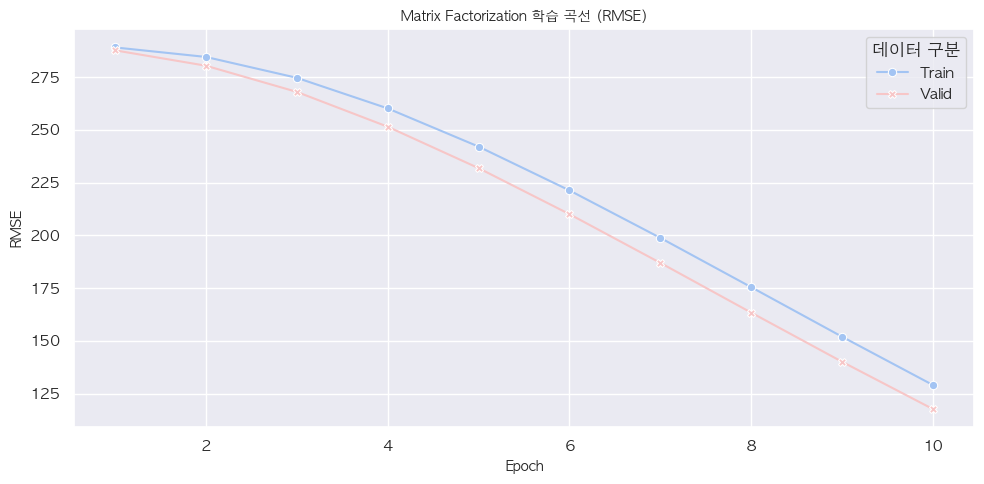

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

# ───────────────────────────────────────────────
# seaborn 스타일 설정
# ───────────────────────────────────────────────
sns.set_theme(
    font="AppleGothic",
    style="darkgrid",
    rc={
    "axes.unicode_minus": False, # 한글/음수 표시 깨짐 방지
    # "axes.facecolor": "#2b2b2b",  
    # "figure.facecolor": "#2b2b2b",
    # "savefig.facecolor": "#2b2b2b",
    # "grid.color": "#4f4f4f",
    # "axes.edgecolor": "#DDDDDD",
    # "axes.labelcolor": "#DDDDDD",
    # "text.color": "#DDDDDD",
    # "xtick.color": "#DDDDDD",
    # "ytick.color": "#DDDDDD"
    }
)  

# 데이터프레임으로 정리 (seaborn은 long-form 구조가 보기 좋음)
epochs = range(1, len(train_rmse_list) + 1)
df = pd.DataFrame({
    "Epoch": list(epochs) * 2,
    "RMSE": train_rmse_list + valid_rmse_list,
    "Type": ["Train"] * len(train_rmse_list) + ["Valid"] * len(valid_rmse_list)
})

# ───────────────────────────────────────────────
# 시각화
# ───────────────────────────────────────────────
plt.figure(figsize=(10, 5))
sns.lineplot(
    data=df, x="Epoch", y="RMSE", hue="Type", style="Type",
    markers=True, dashes=False,
    palette=["#A3C4F3", "#F7C6C7"]
)
plt.title("Matrix Factorization 학습 곡선 (RMSE)", fontsize=10)
plt.xlabel("Epoch", fontsize=10)
plt.ylabel("RMSE", fontsize=10)
plt.legend(title="데이터 구분")
plt.tight_layout()
plt.show()

In [25]:
model.eval()  # 출력 없음: 최종 평가 모드
with torch.no_grad():  # 출력 없음: 그래디언트 비활성화
    total_test = 0.0  # 예: 초기값 0.0
    for users_batch, items_batch, ratings_batch in test_loader:
        preds = model(users_batch.to(device), items_batch.to(device))  # 예: preds[:4] -> tensor([7.48, 6.80, ...])
        loss = criterion(preds, ratings_batch.to(device))  # 예: loss.item() -> 1.07
        total_test += loss.item() * len(ratings_batch)  # 예: total_test -> 2150.0 (누적)
    test_rmse = (total_test / len(test_x)) ** 0.5  # 예: test_rmse -> 1.04

print(f"Test RMSE {test_rmse:.3f}")  # 예: "Test RMSE 1.042"

user_example = 0  # 예: 첫 번째 인코딩된 사용자
with torch.no_grad():  # 출력 없음
    user_vec = model.user_factors.weight[user_example]  # 예: user_vec[:5] -> tensor([0.078, -0.012, 0.044, ...])
    scores = (model.item_factors.weight @ user_vec).cpu().numpy()  # 예: scores[:5] -> array([7.2 , 6.8 , 6.4 , ...])
top_items = scores.argsort()[::-1][:20]  # 예: top_items -> array([ 105,  320,  250, ...])
recommended_anime_ids = [items[idx] for idx in top_items]  # 예: recommended_anime_ids -> [5114, 9253, 32281, ...]
recommended_anime_ids  # 예시 출력: [5114, 9253, 11061, 30276, 28977, 21, 11061, 199, 6547, 22535]

Test RMSE 10.816


[35252,
 5258,
 40776,
 8630,
 431,
 32935,
 40046,
 1865,
 34403,
 1852,
 17729,
 20853,
 5630,
 1889,
 9958,
 20583,
 21681,
 37259,
 34281,
 22835]

In [24]:
anime = pd.read_csv("data/animelist-dataset/anime-dataset-2023.csv")

In [25]:
anime.head()

,anime_id,Name,English name,Other name,Score,Genres,Synopsis,Type,Episodes,Aired,...,Studios,Source,Duration,Rating,Rank,Popularity,Favorites,Scored By,Members,Image URL
0,1,Cowboy Bebop,Cowboy Bebop,カウボーイビバップ,8.75,"Action, Award Winning, Sci-Fi","Crime is timeless. By the year 2071, humanity ...",TV,26.0,"Apr 3, 1998 to Apr 24, 1999",...,Sunrise,Original,24 min per ep,R - 17+ (violence & profanity),41.0,43,78525,914193.0,1771505,https://cdn.myanimelist.net/images/anime/4/196...
1,5,Cowboy Bebop: Tengoku no Tobira,Cowboy Bebop: The Movie,カウボーイビバップ 天国の扉,8.38,"Action, Sci-Fi","Another day, another bounty—such is the life o...",Movie,1.0,"Sep 1, 2001",...,Bones,Original,1 hr 55 min,R - 17+ (violence & profanity),189.0,602,1448,206248.0,360978,https://cdn.myanimelist.net/images/anime/1439/...
2,6,Trigun,Trigun,トライガン,8.22,"Action, Adventure, Sci-Fi","Vash the Stampede is the man with a $$60,000,0...",TV,26.0,"Apr 1, 1998 to Sep 30, 1998",...,Madhouse,Manga,24 min per ep,PG-13 - Teens 13 or older,328.0,246,15035,356739.0,727252,https://cdn.myanimelist.net/images/anime/7/203...
3,7,Witch Hunter Robin,Witch Hunter Robin,Witch Hunter ROBIN (ウイッチハンターロビン),7.25,"Action, Drama, Mystery, Supernatural",Robin Sena is a powerful craft user drafted in...,TV,26.0,"Jul 3, 2002 to Dec 25, 2002",...,Sunrise,Original,25 min per ep,PG-13 - Teens 13 or older,2764.0,1795,613,42829.0,111931,https://cdn.myanimelist.net/images/anime/10/19...
4,8,Bouken Ou Beet,Beet the Vandel Buster,冒険王ビィト,6.94,"Adventure, Fantasy, Supernatural",It is the dark century and the people are suff...,TV,52.0,"Sep 30, 2004 to Sep 29, 2005",...,Toei Animation,Manga,23 min per ep,PG - Children,4240.0,5126,14,6413.0,15001,https://cdn.myanimelist.net/images/anime/7/215...


In [26]:
filtered_anime = anime[anime["anime_id"].isin(recommended_anime_ids)]


In [27]:
filtered_anime

,anime_id,Name,English name,Other name,Score,Genres,Synopsis,Type,Episodes,Aired,...,Studios,Source,Duration,Rating,Rank,Popularity,Favorites,Scored By,Members,Image URL
2896,3247,Love Hina Final Selection,Love Hina Final Selection,ラブひなFINAL SELECTION ～アニメ総集編&LOVE HINA LIVE in ...,7.16,"Comedy, Romance, Ecchi","Love Hina Final Selection, tells the story of ...",OVA,1.0,"Sep 5, 2001",...,Xebec,Manga,28 min,PG-13 - Teens 13 or older,3249.0,3706,23,14924.0,31563,https://cdn.myanimelist.net/images/anime/10/82...
3727,4601,Fairy Forest Remi-chan,Fairy Forest Remi-chan,フェアリーフォレスト レミちゃん,4.48,Hentai,Take a mystical journey to an enchanted forest...,OVA,1.0,"Apr 21, 2000",...,UNKNOWN,Unknown,21 min,Rx - Hentai,UNKNOWN,10130,3,935.0,2375,https://cdn.myanimelist.net/images/anime/1114/...
4186,5560,Aoi Kokuhaku,UNKNOWN,蒼い告白,4.58,Hentai,No description available for this anime.,OVA,1.0,"Feb 25, 2003",...,Studio OX,Unknown,25 min,Rx - Hentai,UNKNOWN,12229,0,311.0,1139,https://cdn.myanimelist.net/images/anime/8/115...
4331,5869,Chou no Sainan,The Unlucky Butterfly,蝶のさいなん,5.26,Action,A short movie from 1931 about a mouse stealing...,Movie,1.0,1931,...,UNKNOWN,Original,8 min,G - All Ages,11462.0,11979,0,689.0,1241,https://cdn.myanimelist.net/images/anime/1097/...
5259,8194,Akuma-kun,UNKNOWN,悪魔くん,6.73,"Adventure, Fantasy, Horror, Supernatural",The age of the demons has begun. Dr Faust has ...,TV,42.0,"Apr 15, 1989 to Mar 24, 1990",...,Toei Animation,Manga,25 min per ep,G - All Ages,5184.0,11838,2,308.0,1304,https://cdn.myanimelist.net/images/anime/8/614...
6204,10460,Kimi to Boku.,You and Me.,君と僕。,7.66,"Comedy, Drama, Romance, Slice of Life",Four childhood friends are in their second yea...,TV,13.0,"Oct 4, 2011 to Dec 27, 2011",...,J.C.Staff,Manga,24 min per ep,PG-13 - Teens 13 or older,1226.0,1225,1376,60843.0,180492,https://cdn.myanimelist.net/images/anime/4/349...
9746,28419,Katsura Hime,Princess Katsura,かつら姫,5.07,"Action, Comedy",Short film about a princess being kidnapped.,Movie,1.0,1937,...,UNKNOWN,Original,2 min,G - All Ages,11838.0,13526,0,389.0,768,https://cdn.myanimelist.net/images/anime/12/68...
9940,29317,Saenai Heroine no Sodatekata: Ai to Seishun no...,Saekano: Fan Service of Love and Youth,冴えない彼女の育てかた #0 「愛と青春のサービス回」,7.07,"Comedy, Romance, Ecchi","Tomoya Aki, Megumi Katou, Eriri Spencer Sawamu...",Special,1.0,"Jan 9, 2015",...,A-1 Pictures,Light novel,23 min,PG-13 - Teens 13 or older,3684.0,1664,87,69734.0,123527,https://cdn.myanimelist.net/images/anime/6/704...
9998,29481,Kakinoki Mokkii,UNKNOWN,柿の木モッキィ,5.26,Fantasy,A persimmon tree wants to grow more fruit and ...,Special,1.0,"Jun 30, 2008",...,UNKNOWN,Unknown,5 min,G - All Ages,11465.0,15692,0,189.0,421,https://cdn.myanimelist.net/images/anime/4/708...
10051,29645,Jikan,Time,時間,4.68,Avant Garde,"Experimental animation by Manabe Hiroshi, memb...",Movie,1.0,1963,...,UNKNOWN,Original,7 min,G - All Ages,12335.0,15381,1,179.0,449,https://cdn.myanimelist.net/images/anime/2/712...


In [2]:
import pandas as pd
a = pd.read_csv("data/animelist-dataset/users-score-2023.csv")

In [3]:
a.head()

,user_id,Username,anime_id,Anime Title,rating
0,1,Xinil,21,One Piece,9
1,1,Xinil,48,.hack//Sign,7
2,1,Xinil,320,A Kite,5
3,1,Xinil,49,Aa! Megami-sama!,8
4,1,Xinil,304,Aa! Megami-sama! Movie,8


In [12]:
# pip install sentence-transformers
import re
import numpy as np
import pandas as pd
from typing import List, Tuple
from sentence_transformers import SentenceTransformer

# ---------- 0) 노이즈에 강한 정규화 ----------
# - 한글/히라가나/가타카나/한자/영문/숫자만 남김
# - 괄호/부제/기호/이상문자 제거 후 공백 정리
NOISE_KEEP = re.compile(r"[^0-9A-Za-z\uAC00-\uD7A3\u3040-\u309F\u30A0-\u30FF\u4E00-\u9FFF\s]+")

def normalize_title(s: str) -> str:
    s = s.lower()
    s = re.sub(r"\(.*?\)", " ", s)              # 괄호 내 부제 제거
    s = NOISE_KEEP.sub(" ", s)                  # 허용 외 문자 제거
    s = re.sub(r"\s+", " ", s).strip()          # 공백 정리
    return s

# ---------- 1) 예시 마스터(원제만; 필요시 CSV로 교체) ----------
titles = [
    # Naruto-verse
    {"anime_id": 1,  "title": "Naruto"},
    {"anime_id": 2,  "title": "Naruto Shippuden"},
    {"anime_id": 3,  "title": "Boruto: Naruto Next Generations"},
    # Big shonen
    {"anime_id": 4,  "title": "One Piece"},
    {"anime_id": 5,  "title": "Bleach"},
    {"anime_id": 6,  "title": "Bleach: Thousand-Year Blood War"},
    {"anime_id": 7,  "title": "Dragon Ball Z"},
    {"anime_id": 8,  "title": "JoJo's Bizarre Adventure"},
    {"anime_id": 9,  "title": "Slam Dunk"},
    {"anime_id": 10, "title": "Detective Conan"},
    # Modern hits
    {"anime_id": 11, "title": "Attack on Titan"},
    {"anime_id": 12, "title": "Demon Slayer: Kimetsu no Yaiba"},
    {"anime_id": 13, "title": "Jujutsu Kaisen"},
    {"anime_id": 14, "title": "My Hero Academia"},
    {"anime_id": 15, "title": "Chainsaw Man"},
    {"anime_id": 16, "title": "SPY×FAMILY"},
    {"anime_id": 17, "title": "Haikyu!!"},
    {"anime_id": 18, "title": "Blue Lock"},
    {"anime_id": 19, "title": "Oshi no Ko"},
    {"anime_id": 20, "title": "Frieren: Beyond Journey's End"},
    # Classics
    {"anime_id": 21, "title": "Fullmetal Alchemist: Brotherhood"},
    {"anime_id": 22, "title": "Death Note"},
    {"anime_id": 23, "title": "Neon Genesis Evangelion"},
    {"anime_id": 24, "title": "Steins;Gate"},
    {"anime_id": 25, "title": "Made in Abyss"},
    # SAO / Re:Zero / Mushoku
    {"anime_id": 26, "title": "Sword Art Online"},
    {"anime_id": 27, "title": "Re:Zero − Starting Life in Another World"},
    {"anime_id": 28, "title": "Mushoku Tensei: Jobless Reincarnation"},
    # Sports / Misc
    {"anime_id": 29, "title": "Kaguya-sama: Love Is War"},
    {"anime_id": 30, "title": "Vinland Saga"},
    {"anime_id": 31, "title": "Dr. Stone"},
    {"anime_id": 32, "title": "Mob Psycho 100"},
    # Your examples
    {"anime_id": 33, "title": "Dandadan"},
]

titles_df = pd.DataFrame(titles)

# ---------- 2) 인덱스 구축 ----------
def build_index(df: pd.DataFrame, model_name: str = "paraphrase-multilingual-mpnet-base-v2"):
    docs = [normalize_title(t) for t in df["title"].tolist()]
    id_map = df["anime_id"].tolist()
    model = SentenceTransformer(model_name)
    emb = model.encode(docs, normalize_embeddings=True).astype("float32")  # (N, d)
    return model, emb, docs, id_map

model, emb, docs, id_map = build_index(titles_df)

# ---------- 3) 단건 검색 ----------
def search_title(q: str, k: int = 5, cutoff: float = 0.55) -> List[Tuple[int, float, str]]:
    qn = normalize_title(q)
    qv = model.encode([qn], normalize_embeddings=True).astype("float32")[0]
    sims = emb @ qv  # 코사인 유사도
    k = min(k, len(sims))
    idx = np.argpartition(-sims, k-1)[:k]
    idx = idx[np.argsort(-sims[idx])]
    hits = [(id_map[i], float(sims[i]), docs[i]) for i in idx if sims[i] >= cutoff]
    return hits  # [(anime_id, score, matched_norm_title)]

# ---------- 4) 배치 검색 (여러 질의 한 번에) ----------
def batch_search(queries: List[str], k: int = 5, cutoff: float = 0.55):
    qn = [normalize_title(q) for q in queries]
    qv = model.encode(qn, normalize_embeddings=True).astype("float32")  # (B, d)
    sims = qv @ emb.T  # (B, N)
    results = []
    for r in range(sims.shape[0]):
        row = sims[r]
        kk = min(k, len(row))
        idx = np.argpartition(-row, kk-1)[:kk]
        idx = idx[np.argsort(-row[idx])]
        hits = [(id_map[i], float(row[i]), docs[i]) for i in idx if row[i] >= cutoff]
        results.append(hits)
    return results

# ---------- 5) 데모 ----------
queries = [
    "나루토 질풍전ㅣㄴㅁ;ㅣㅇ;",   # → Naruto Shippuden
    "단다단1-₩129812ㅑ",          # → Dandadan
    "귀멸의 칼날",                 # → Demon Slayer: Kimetsu no Yaiba (ko 표기)
    "진격의거인!!",               # → Attack on Titan
    "강철의 연금술사 브라더후드",   # → Fullmetal Alchemist: Brotherhood
    "스파이 패밀리",               # → SPY×FAMILY
    "재:제로",                     # → Re:Zero − Starting Life in Another World
]
for q, hits in zip(queries, batch_search(queries, k=5, cutoff=0.50)):
    print(q, "->", hits[:3])

나루토 질풍전ㅣㄴㅁ;ㅣㅇ; -> [(2, 0.7875925898551941, 'naruto shippuden'), (1, 0.7868596315383911, 'naruto'), (3, 0.6323137283325195, 'boruto naruto next generations')]
단다단1-₩129812ㅑ -> [(33, 0.5930259823799133, 'dandadan')]
귀멸의 칼날 -> [(13, 0.6246535778045654, 'jujutsu kaisen'), (26, 0.5025020241737366, 'sword art online')]
진격의거인!! -> [(33, 0.5972070097923279, 'dandadan'), (13, 0.5902509689331055, 'jujutsu kaisen')]
강철의 연금술사 브라더후드 -> [(31, 0.5447084307670593, 'dr stone'), (13, 0.5247730016708374, 'jujutsu kaisen'), (33, 0.5068535208702087, 'dandadan')]
스파이 패밀리 -> [(16, 0.7050999402999878, 'spy family')]
재:제로 -> [(27, 0.6375916004180908, 're zero starting life in another world'), (33, 0.5122488737106323, 'dandadan')]


In [ ]:
import pandas as pd
a = pd.read_csv("data/animelist-dataset/users-score-2023.csv")

In [11]:
a.head()

,user_id,Username,anime_id,Anime Title,rating
0,1,Xinil,21,One Piece,9
1,1,Xinil,48,.hack//Sign,7
2,1,Xinil,320,A Kite,5
3,1,Xinil,49,Aa! Megami-sama!,8
4,1,Xinil,304,Aa! Megami-sama! Movie,8


In [ ]:
anime_pairs = set(zip(a["anime_id"], a["Anime Title"]))
print(anime_pairs)

{(146, 'Kono Minikuku mo Utsukushii Sekai'), (3007, 'Bronze: Kouji Nanjo Cathexis'), (37663, 'God Eater Reso Nantoka Gekijou: Nagerareta Shokupan'), (41296, 'Valhait Rising: Kandou e.'), (27947, 'Lupin III (2015)'), (37407, 'Penguin Highway'), (37433, 'Wakaokami wa Shougakusei!'), (38940, 'Cop Craft'), (5658, 'Great Mazinger'), (2615, 'Otome wa Boku ni Koishiteru Special'), (22623, 'Pochacco no Ninjin Hata wa Oosawagi'), (8235, 'Muumin (1972)'), (34350, 'Alice to Zouroku'), (51128, 'Noumin Kanren no Skill bakka Agetetara Nazeka Tsuyoku Natta.'), (36729, 'Fate/Apocrypha Recaps'), (1471, 'City Hunter 2'), (1784, 'Injuu Nerawareta Hanayome'), (38739, 'Kidou Senshi Gundam UC Perfectibility'), (1056, 'Good Morning Call'), (19115, 'Giovanni no Shima'), (16620, 'Robot King'), (48680, 'Tesla Note'), (6918, 'Wolverine'), (25801, 'Shouwa Genroku Rakugo Shinjuu: Yotarou Hourou-hen'), (14211, 'Instant History'), (2421, 'Super Kuma-san'), (31109, 'Hatsukoi Monster'), (39172, 'Kaisei'), (16822, 'Uju

In [19]:
print(list(t[1] for t in list(anime_pairs)))

['Kono Minikuku mo Utsukushii Sekai', 'Bronze: Kouji Nanjo Cathexis', 'God Eater Reso Nantoka Gekijou: Nagerareta Shokupan', 'Valhait Rising: Kandou e.', 'Lupin III (2015)', 'Penguin Highway', 'Wakaokami wa Shougakusei!', 'Cop Craft', 'Great Mazinger', 'Otome wa Boku ni Koishiteru Special', 'Pochacco no Ninjin Hata wa Oosawagi', 'Muumin (1972)', 'Alice to Zouroku', 'Noumin Kanren no Skill bakka Agetetara Nazeka Tsuyoku Natta.', 'Fate/Apocrypha Recaps', 'City Hunter 2', 'Injuu Nerawareta Hanayome', 'Kidou Senshi Gundam UC Perfectibility', 'Good Morning Call', 'Giovanni no Shima', 'Robot King', 'Tesla Note', 'Wolverine', 'Shouwa Genroku Rakugo Shinjuu: Yotarou Hourou-hen', 'Instant History', 'Super Kuma-san', 'Hatsukoi Monster', 'Kaisei', 'Uju Heukgisa', 'Sizq', 'Bi-chiku Beach: Nangoku Nyuujoku Satsueikai', 'Naked Wolves', 'Yakusai Kochou', 'Notari Matsutarou', 'Accept', 'Kirara', 'Another: The Other - Inga', 'Ketsuekigata-kun! Featuring Yuri & Nasuno', 'Succubus Yondara Gibo ga Kita!?'

In [2]:
# pip install sentence-transformers
import re
import numpy as np
import pandas as pd
from typing import List, Tuple, Optional, Iterable
from sentence_transformers import SentenceTransformer

# ---------------- 0) 정규화 ----------------
NOISE_KEEP = re.compile(r"[^0-9A-Za-z\uAC00-\uD7A3\u3040-\u309F\u30A0-\u30FF\u4E00-\u9FFF\s]+")

def normalize_title(s: str) -> str:
    s = s.lower()
    s = re.sub(r"\(.*?\)", " ", s)      # 괄호 내 부제 제거
    s = NOISE_KEEP.sub(" ", s)          # 허용 외 문자 제거
    s = re.sub(r"\s+", " ", s).strip()  # 공백 정리
    return s

# ---------------- 1) anime_pairs -> 인덱스 ----------------
def build_index_from_pairs(anime_pairs: Iterable[Tuple[int, str]],
                           model_name: str = "paraphrase-multilingual-mpnet-base-v2"):
    df = pd.DataFrame(anime_pairs, columns=["anime_id", "title"])
    docs = [normalize_title(t) for t in df["title"].tolist()]
    id_map = df["anime_id"].tolist()
    title_map = df["title"].tolist()  # 원제 복원용
    model = SentenceTransformer(model_name)
    emb = model.encode(docs, normalize_embeddings=True).astype("float32")  # (N, d)
    return model, emb, docs, id_map, title_map

# ---------------- 2) Top-1 검색 ----------------
def search_top1(q: str,
                model: SentenceTransformer,
                emb: np.ndarray,
                docs: List[str],
                id_map: List[int],
                title_map: List[str],
                cutoff: float = 0.55) -> Optional[Tuple[int, str, float, str]]:
    """
    반환: (anime_id, original_title, score, matched_norm_title) or None
    """
    qn = normalize_title(q)
    qv = model.encode([qn], normalize_embeddings=True).astype("float32")[0]
    sims = emb @ qv  # (N,)
    i = int(np.argmax(sims))
    score = float(sims[i])
    if score < cutoff:
        return None
    return id_map[i], title_map[i], score, docs[i]

def batch_top1(queries: List[str],
               model: SentenceTransformer,
               emb: np.ndarray,
               docs: List[str],
               id_map: List[int],
               title_map: List[str],
               cutoff: float = 0.55):
    results = []
    for q in queries:
        hit = search_top1(q, model, emb, docs, id_map, title_map, cutoff=cutoff)
        results.append((q, hit))
    return results

# ---------------- 3) 예시 사용 ----------------
# 예: 사용자가 제공한 anime_pairs (id, title) 집합

model, emb, docs, id_map, title_map = build_index_from_pairs(anime_pairs)

queries = [
    "나루토 질풍전ㅣㄴㅁ;ㅣㅇ;",   # → Naruto Shippuden
    "단다단1-₩129812ㅑ",          # → Dandadan
    "귀멸의 칼날",                 # → Demon Slayer: Kimetsu no Yaiba
    "진격의거인!!",               # → Attack on Titan
    "강철의 연금술사 브라더후드",   # → Fullmetal Alchemist: Brotherhood
    "스파이 패밀리",               # → SPY×FAMILY
    "재:제로",                     # → Re:Zero − Starting Life in Another World
]

results = batch_top1(queries, model, emb, docs, id_map, title_map, cutoff=0.50)

for q, hit in results:
    if hit is None:
        print(f"{q} -> None (below cutoff)")
    else:
        aid, title, score, matched_norm = hit
        print(f"{q} -> anime_id={aid}, title='{title}', score={score:.3f}, matched='{matched_norm}'")

NameError: name 'anime_pairs' is not defined

In [4]:
import pandas as pd

animet = pd.read_csv("data/animelist-dataset/anime-dataset-2023.csv",usecols=['Other name'])

In [5]:
samples = list(animet['Other name'])

In [ ]:
# pip install -U transformers sentencepiece torch pykakasi --quiet
import re, torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from pykakasi import kakasi

MODEL = "facebook/mbart-large-50-many-to-many-mmt"
tok = AutoTokenizer.from_pretrained(MODEL, use_fast=False)
mt  = AutoModelForSeq2SeqLM.from_pretrained(MODEL)
mt.eval()

kks = kakasi()

# (참고) 일본어 → 한국어로 번역
def ja2ko(text: str) -> str:
    tok.src_lang = "ja_XX"
    enc = tok(text, return_tensors="pt")
    with torch.inference_mode():
        out = mt.generate(
            **enc,
            forced_bos_token_id=tok.convert_tokens_to_ids("ko_KR"),
            num_beams=5,
            length_penalty=1.1,
            max_new_tokens=64,
            early_stopping=True,
        )
    result = tok.batch_decode(out, skip_special_tokens=True)[0].strip()
    # 불필요한 접두어 제거
    result = re.sub(r"^(한국어|번역).*?:", "", result).strip()
    return result

# 언어 판별 유틸
def has_kana(s):  return any('\u3040' <= ch <= '\u30ff' for ch in s)
def has_kanji(s): return any('\u4e00' <= ch <= '\u9fff' for ch in s)
def has_hangul(s): return any('\uac00' <= ch <= '\ud7a3' for ch in s)

# 로마자 → 가나 변환
def romaji_to_hira(s: str) -> str:
    return "".join(part["hira"] for part in kks.convert(s)).strip()

def to_korean_title(t: str) -> str:
    t = t.strip()
    if not t:
        return ""

    # 1️⃣ 이미 한글 → 그대로
    if has_hangul(t):
        return t

    # 2️⃣ 일본어(가나 또는 한자 포함) → 일본어→한국어 번역
    if has_kana(t) or has_kanji(t):
        return ja2ko(t)

    # 3️⃣ 로마자 일본어 → 가나 변환 → 번역
    hira = romaji_to_hira(t)
    if hira:
        return ja2ko(hira)

    # 4️⃣ 영어류 → 영어→한국어 번역
    tok.src_lang = "en_XX"
    enc = tok(t, return_tensors="pt")
    with torch.inference_mode():
        out = mt.generate(
            **enc,
            forced_bos_token_id=tok.convert_tokens_to_ids("ko_KR"),
            num_beams=5, length_penalty=1.1, max_new_tokens=64
        )
    return tok.batch_decode(out, skip_special_tokens=True)[0].strip()



# 사용 예시
for s in samples:
    print(s, " → ", to_korean_title(s))

カウボーイビバップ  →  쿠보이 비바프
カウボーイビバップ 天国の扉  →  카보이 비바프 천국의扉
トライガン  →  트라이ガン
Witch Hunter ROBIN (ウイッチハンターロビン)  →  Witch Hunter ROBIN
冒険王ビィト  →  Adventure King 비트
アイシールド21  →  아이시ल्ड 21
ハチミツとクローバー  →  ハチミツとクローバー
ハングリーハート Wild Striker  →  햄리ハート Wild Striker
頭文字〈イニシャル〉D FOURTH STAGE  →  "Inicial" D FOURTH STAGE
モンスター  →  Monster
ナルト  →  ナル트
ONE PIECE  →  ONE PIECE
テニスの王子様  →  테니스王子
リングにかけろ１  →  링을 틀어주세요.
スクールランブル  →  학교ランブル
砂ぼうず  →  砂ぼうず
TEXHNOLYZE  →  TEXHNOLYZE
トリニティ・ブラッド  →  트리니 브래드
焼きたて!! ジャぱん  →  焼きた!!
ジパング  →  짐작
新世紀エヴァンゲリオン  →  신세기 에반ゲ리온
新世紀エヴァンゲリオン劇場版 シト新生  →  New Century Evangelion Theatre Version
新世紀エヴァンゲリオン劇場版 THE END OF EVANGELION  →  The End of EVANGELION
剣風伝奇ベルセルク  →  剣風伝奇ベルセルク
GHOST IN THE SHELL（攻殻機動隊）  →  GHOST IN THE SHELL
るろうに剣心―明治剣客浪漫譚―追憶編  →  るろう 剣心 -明治剣客 로맨 -追憶編
るろうに剣心 -明治剣客浪漫譚-  →  るろう no剣心 -明治剣客浪漫譚-
るろうに剣心 -明治剣客浪漫譚- 維新志士への鎮魂歌  →  るろうに剣心 -明治剣客浪漫譚- 維新志士への鎮魂歌
AKIRA（アキラ）  →  아키라
.hack//SIGN  →  .hack//SIGN
ああっ女神さまっ  →  아, goddess.
ああっ女神さまっ  →  아, goddess.
天使禁猟区  →  Angel Proh

KeyboardInterrupt: 

In [20]:
# pip install -U transformers sentencepiece torch langdetect --quiet
import torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from langdetect import detect

MODEL = "facebook/mbart-large-50-many-to-many-mmt"

# 핵심: use_fast=False 로드 → protobuf 불필요
tok = AutoTokenizer.from_pretrained(MODEL, use_fast=False)
mt  = AutoModelForSeq2SeqLM.from_pretrained(
    MODEL,
    use_safetensors=True,
    low_cpu_mem_usage=False,
    dtype=torch.float32,
)
mt.eval()

def mbart_to_ko(text: str) -> str:
    t = text.strip()
    if not t:
        return ""
    # 간단 언어 판별 (짧은 제목 보정)
    try:
        lang = detect(t)
    except:
        lang = "en"
    if any('\u3040' <= ch <= '\u30ff' for ch in t):  # 히라/가타카나
        lang = "ja"
    if any('\uac00' <= ch <= '\ud7a3' for ch in t):  # 이미 한글
        return t

    # mBART-50 언어 코드
    src = "en_XX" if lang.startswith("en") else "ja_XX"
    tok.src_lang = src

    enc = tok(t, return_tensors="pt")
    with torch.inference_mode():
        out_ids = mt.generate(
            **enc,
            forced_bos_token_id=tok.convert_tokens_to_ids("ko_KR"),
            max_new_tokens=64,
        )
    return tok.batch_decode(out_ids, skip_special_tokens=True)[0].strip()

# 테스트
# samples = [
#     "Attack on Titan",
#     "Demon Slayer: Kimetsu no Yaiba",
#     "ジョジョの奇妙な冒険",
#     "SPY×FAMILY",
# ]
samples = list(t[1] for t in list(anime_pairs))
for s in samples:
    print(s, "→", mbart_to_ko(s))

Kono Minikuku mo Utsukushii Sekai → Kono Minikuku mo Utsukushii Sekai
Bronze: Kouji Nanjo Cathexis → Bronze: Kouji Nanjo Cathexis
God Eater Reso Nantoka Gekijou: Nagerareta Shokupan → God Eater Reso Nantoka Gekijou: Nagerareta Shokupan
Valhait Rising: Kandou e. → Valhait Rising: Kandou e.
Lupin III (2015) → Lupin III (2015)
Penguin Highway → 펭귄 하이웨이
Wakaokami wa Shougakusei! → Wakaokami wa Shougakusei!
Cop Craft → 코프 크래프트
Great Mazinger → Great Mazinger
Otome wa Boku ni Koishiteru Special → Otome wa Boku ni Koishiteru Special
Pochacco no Ninjin Hata wa Oosawagi → Pochacco no Ninjin Hata wa Oosawagi
Muumin (1972) → Muumin (1972)
Alice to Zouroku → Alice to Zouroku
Noumin Kanren no Skill bakka Agetetara Nazeka Tsuyoku Natta. → Noumin Kanren no Skill bakka Agetetara Nazeka Tsuyoku Natta.
Fate/Apocrypha Recaps → Fate/Apocrypha Recaps
City Hunter 2 → 시 헌터 2
Injuu Nerawareta Hanayome → Injuu Nerawareta Hanayome
Kidou Senshi Gundam UC Perfectibility → 키두 센시  Gundam UC 완벽성
Good Morning Call → 

KeyboardInterrupt: 

In [25]:
# 필요한 패키지 (한 번만 설치)
# pip install -U pykakasi transformers sentencepiece torch langdetect --quiet

import re
import torch
from langdetect import detect
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from pykakasi import kakasi

MODEL = "facebook/mbart-large-50-many-to-many-mmt"

# mBART 로드
tok = AutoTokenizer.from_pretrained(MODEL, use_fast=False)
mt  = AutoModelForSeq2SeqLM.from_pretrained(
    MODEL,
    use_safetensors=True,
    low_cpu_mem_usage=False,
    dtype=torch.float32,
)
mt.eval()

# 로마자 -> 가나 변환기
kks = kakasi()

# 작품명 공식/관용 한글 타이틀 우선 매핑
OVERRIDE = {
    # 영어/일본어 원제 : 한국 통용 제목
    "Attack on Titan": "진격의 거인",
    "Demon Slayer: Kimetsu no Yaiba": "귀멸의 칼날",
    "SPY×FAMILY": "SPY×FAMILY",  # 보통 그대로 표기
    "SPY X FAMILY": "스파이 패밀리",
    "SPYXFAMILY": "스파이 패밀리",
    "JoJo's Bizarre Adventure": "죠죠의 기묘한 모험",
    "Great Mazinger": "그레이트 마징가",
    "Cop Craft": "코프 크래프트",
    "Penguin Highway": "펭귄 하이웨이",
    # 필요시 계속 추가
}

# 유니코드 범위 체크
def has_kana(s: str) -> bool:
    return any('\u3040' <= ch <= '\u30ff' for ch in s)  # 히라/가타카나

def has_hangul(s: str) -> bool:
    return any('\uac00' <= ch <= '\ud7a3' for ch in s)

def is_romaji_like_japanese(s: str) -> bool:
    """
    일본어 로마자를 대략 감지: 한글/가나/한자 없고,
    공통 조사/접사/패턴이 포함되면 True
    """
    if has_hangul(s) or has_kana(s):
        return False
    # 한자 범위
    if any('\u4e00' <= ch <= '\u9fff' for ch in s):
        return False

    low = s.lower()
    tokens = re.findall(r"[a-zA-Z]+", low)
    if not tokens:
        return False

    # 흔한 로마자 일본어 패턴/조사/접사
    jp_markers = [
        " no ", " wa ", " ga ", " wo ", " to ", " mo ", " de ", " ni ",
        "kara ", " made", " shou", " chou", " jou", " kyo", " kyou",
        " gei", " geki", " gekijou", " gekijō", " shoku", " pan", " shokupan",
        " kanojo", " sekai", " utsukushii", " minikuku", " nagerareta",
        " wakaokami", " shougakusei", " kandou", " e.", " reso", " nantoka",
    ]
    pad = " " + low + " "
    score = sum(1 for m in jp_markers if m in pad)

    # 모음-자음 패턴이 과도하게 반복되면 로마자 일본어로 가정
    vowel_ratio = sum(ch in "aeiou" for ch in low) / max(1, sum(ch.isalpha() for ch in low))
    looks_romaji = vowel_ratio > 0.30 and score >= 1
    return looks_romaji

def en_like(s: str) -> bool:
    # 한글/가나/한자 없고, 알파벳+숫자/기호 위주면 영어류로 간주
    if has_hangul(s) or has_kana(s):
        return False
    if any('\u4e00' <= ch <= '\u9fff' for ch in s):
        return False
    return True

def mbart_translate(text: str, src_lang: str, tgt_lang: str = "ko_KR",
                    prompt_hint: str = "", beams: int = 5) -> str:
    tok.src_lang = src_lang
    inp = prompt_hint + text if prompt_hint else text
    enc = tok(inp, return_tensors="pt")
    with torch.inference_mode():
        out_ids = mt.generate(
            **enc,
            forced_bos_token_id=tok.convert_tokens_to_ids(tgt_lang),
            num_beams=beams,
            length_penalty=1.1,
            no_repeat_ngram_size=2,
            max_new_tokens=64,
            early_stopping=True,
            do_sample=False,
        )
    return tok.batch_decode(out_ids, skip_special_tokens=True)[0].strip()

def romaji_to_hira(s: str) -> str:
    return "".join(part["hira"] for part in kks.convert(s)).strip()

def mbart_to_ko(text: str) -> str:
    t = text.strip()
    if not t:
        return ""

    # 0) override 우선
    if t in OVERRIDE:
        return OVERRIDE[t]

    # 1) 이미 한글이면 그대로
    if has_hangul(t):
        return t

    # 2) 가나/한자 → 일본어로 간주 후 번역
    if has_kana(t) or any('\u4e00' <= ch <= '\u9fff' for ch in t):
        return mbart_translate(t, src_lang="ja_XX")

    # 3) 로마자 일본어 감지 → 가나 변환 → ja→ko
    if is_romaji_like_japanese(t):
        hira = romaji_to_hira(t)
        if hira:
            out = mbart_translate(hira, src_lang="ja_XX")
            # 결과가 입력과 거의 동일(복사)하면 힌트 붙여 재시도
            norm_in = re.sub(r"\W+", "", t).lower()
            norm_out = re.sub(r"\W+", "", out).lower()
            if norm_in == norm_out:
                out = mbart_translate(hira, src_lang="ja_XX", prompt_hint="한국어 제목으로 번역: ")
            return out

    # 4) 그 외(대체로 영어류): en→ko 시도
    if en_like(t):
        out = mbart_translate(t, src_lang="en_XX", prompt_hint="Translate to Korean title: ")
        # 복사 방지 재시도
        norm_in = re.sub(r"\W+", "", t).lower()
        norm_out = re.sub(r"\W+", "", out).lower()
        if norm_in == norm_out:
            out = mbart_translate(t, src_lang="en_XX", prompt_hint="한국어 제목: ")
        # 마지막으로 override 스캔(괄호/공백 변형 대비)
        if out == t and t.title() in OVERRIDE:
            return OVERRIDE[t.title()]
        return out

    # 5) 실패 시 원문 반환
    return t

# -------------------------------
# 사용 예시: 질문에 주신 방식 그대로
samples = list(t[1] for t in list(anime_pairs))
for s in samples:
    print(s, "→", mbart_to_ko(s))
# -------------------------------

Kono Minikuku mo Utsukushii Sekai → Korean 제목으로 번역: Kono Minikuku mo Utsukushii Sekai
Bronze: Kouji Nanjo Cathexis → 한국어로 번역하자면: 청동: Kouji Nanjo Cathexis
God Eater Reso Nantoka Gekijou: Nagerareta Shokupan → Korean 제목으로 번역: God Eater Reso Nantoka Gekijou: Nagerareta Shokupan
Valhait Rising: Kandou e. → Korean 제목으로 번역: Valhait Rising: Kandou e.
Lupin III (2015) → 번역주: 루핀 III (2015)
Penguin Highway → 펭귄 하이웨이
Wakaokami wa Shougakusei! → Korean 제목으로 번역: Wakaokami wa Shougakusei!
Cop Craft → 코프 크래프트
Great Mazinger → 그레이트 마징가
Otome wa Boku ni Koishiteru Special → Korean 제목으로 번역: Otome wa Boku ni Koishiteru Special


KeyboardInterrupt: 

In [3]:
import torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

MODEL = "facebook/mbart-large-50-many-to-many-mmt"
tok = AutoTokenizer.from_pretrained(MODEL, use_fast=False)
mt  = AutoModelForSeq2SeqLM.from_pretrained(MODEL)

def mbart_en2ko(title: str) -> str:
    if not title.strip():
        return ""
    tok.src_lang = "en_XX"  # 소스 고정
    enc = tok("Translate to Korean: " + title, return_tensors="pt")  # 프롬프트 힌트로 '복사' 성향 완화
    with torch.inference_mode():
        out = mt.generate(
            **enc,
            forced_bos_token_id=tok.convert_tokens_to_ids("ko_KR"),
            num_beams=5,                # 탐색 확대
            length_penalty=1.1,         # 너무 짧게 끝내지 않게
            no_repeat_ngram_size=2,
            max_new_tokens=64,
            early_stopping=True,
            do_sample=False,
        )
    return tok.batch_decode(out, skip_special_tokens=True)[0].strip()

for s in [
    "Attack on Titan",
    "Demon Slayer: Kimetsu no Yaiba",
    "SPY×FAMILY",
]:
    print(s, "→", mbart_en2ko(s))

Attack on Titan → 한국어로 번역: 타이탄에 대한 공격
Demon Slayer: Kimetsu no Yaiba → 한국어로 번역: Demon Slayer: Kimetsu no Yaiba
SPY×FAMILY → 한국어로 번역: SPY×FAMILY


In [1]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
tok = AutoTokenizer.from_pretrained("facebook/mbart-large-50-many-to-many-mmt")

/opt/anaconda3/envs/sju-project-rec_anime/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from langdetect import detect

MODEL = "facebook/mbart-large-50-many-to-many-mmt"

tok = AutoTokenizer.from_pretrained(MODEL, use_fast=False)
mt  = AutoModelForSeq2SeqLM.from_pretrained(
    MODEL,
    use_safetensors=True,
    low_cpu_mem_usage=False,
    dtype=torch.float32,
)
mt.eval()
print("model device:", next(mt.parameters()).device)  # cpu 여야 정상

def mbart_to_ko(text: str) -> str:
    t = text.strip()
    if not t:
        return ""
    if any('\uac00' <= ch <= '\ud7a3' for ch in t):
        return t
    src_lang = "ja" if any('\u3040' <= ch <= '\u30ff' for ch in t) else "en"
    tok.src_lang = "en_XX" if src_lang=="en" else "ja_XX"

    enc = tok(t, return_tensors="pt")
    with torch.inference_mode():
        out_ids = mt.generate(
            **enc,
            forced_bos_token_id=tok.convert_tokens_to_ids("ko_KR"),
            max_new_tokens=64,
        )
    return tok.batch_decode(out_ids, skip_special_tokens=True)[0].strip()

# 테스트
samples = ["Attack on Titan", "Demon Slayer: Kimetsu no Yaiba", "ジョジョの奇妙な冒険", "SPY×FAMILY"]
for s in samples:
    print(s, "→", mbart_to_ko(s))

model device: cpu
Attack on Titan → 타이탄에 대한 공격
Demon Slayer: Kimetsu no Yaiba → Demon Slayer: Kimetsu no Yaiba
ジョジョの奇妙な冒険 → 조의 이상한 여정
SPY×FAMILY → SPY×FAMILY


In [6]:
# %% 설치 (한 번만)
# %pip install -U transformers datasets peft accelerate sentencepiece torch --quiet

# %% 환경 체크: MPS
import os, torch, random
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
device = "mps" if torch.backends.mps.is_available() else ("cuda" if torch.cuda.is_available() else "cpu")
print("[device]", device)

# %% 미니 데이터셋 만들기 (메모리)
pairs = [
    ("カウボーイビバップ", "카우보이 비밥"),
    ("カウボーイビバップ 天国の扉", "카우보이 비밥 천국의 문"),
    ("トライガン", "트라이건"),
    ("新世紀エヴァンゲリオン", "신세기 에반게리온"),
    ("ナルト", "나루토"),
    ("ONE PIECE", "원피스"),
    ("テニスの王子様", "테니스의 왕자"),
    ("スクールランブル", "스쿨 럼블"),
    ("頭文字〈イニシャル〉D", "이니셜 D"),
    ("頭文字〈イニシャル〉D FOURTH STAGE", "이니셜 D 포스 스테이지"),
    ("ハングリーハート", "헝그리 하트"),
    ("ハングリーハート Wild Striker", "헝그리 하트 와일드 스트라이커"),
    ("ハチミツとクローバー", "허니와 클로버"),
    ("モンスター", "몬스터"),
    ("冒険王ビィト", "모험왕 비트"),
    ("アイシールド21", "아이실드 21"),
    ("機動戦士ガンダム", "기동전사 건담"),
    ("コードギアス 反逆のルルーシュ", "코드 기아스 반역의 를르슈"),
    ("魔法少女まどか☆マギカ", "마법소녀 마도카☆마기카"),
    ("ジパング", "지팡"),
    ("進撃の巨人", "진격의 거인"),
    ("鬼滅の刃", "귀멸의 칼날"),
    ("SPY×FAMILY", "스파이 패밀리"),
    ("ジョジョの奇妙な冒険", "죠죠의 기묘한 모험"),
    ("銀魂", "은혼"),
    ("鋼の錬金術師", "강철의 연금술사"),
    ("デスノート", "데스노트"),
    ("ソードアート・オンライン", "소드 아트 온라인"),
    ("Re:ゼロから始める異世界生活", "Re:제로부터 시작하는 이세계 생활"),
    ("この素晴らしい世界に祝福を！", "이 멋진 세계에 축복을!"),
    ("ノーゲーム・ノーライフ", "노 게임 노 라이프"),
    ("涼宮ハルヒの憂鬱", "스즈미야 하루히의 우울"),
    ("らき☆すた", "러키☆스타"),
    ("けいおん！", "케이온!"),
    ("シュタインズ・ゲート", "슈타인즈 게이트"),
    ("攻殻機動隊", "공각기동대"),
    ("サイコパス", "사이코패스"),
    ("プラスティック・メモリーズ", "플라스틱 메모리즈"),
    ("ヴァイオレット・エヴァーガーデン", "바이올렛 에버가든"),
    ("四月は君の嘘", "4월은 너의 거짓말"),
    ("化物語", "바케모노가타리"),
    ("とある科学の超電磁砲", "어떤 과학의 초전자포"),
    ("とある魔術の禁書目録", "어떤 마법의 금서목록"),
    ("五等分の花嫁", "5등분의 신부"),
]

random.seed(42)
random.shuffle(pairs)
split = int(len(pairs)*0.8)
train_pairs, valid_pairs = pairs[:split], pairs[split:]

from datasets import Dataset
train_ds = Dataset.from_dict({"ja":[j for j,_ in train_pairs], "ko":[k for _,k in train_pairs]})
valid_ds = Dataset.from_dict({"ja":[j for j,_ in valid_pairs], "ko":[k for _,k in valid_pairs]})

print("train/valid:", len(train_ds), len(valid_ds))

# %% 모델/토크나이저 로드 (mBART-50)
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
MODEL = "facebook/mbart-large-50-many-to-many-mmt"
tok = AutoTokenizer.from_pretrained(MODEL, use_fast=False)
base = AutoModelForSeq2SeqLM.from_pretrained(MODEL)
base.to(device)

# %% LoRA 장착
from peft import LoraConfig, get_peft_model
peft_cfg = LoraConfig(
    task_type="SEQ_2_SEQ_LM",
    r=16, lora_alpha=32, lora_dropout=0.05,
    target_modules=["q_proj","k_proj","v_proj","out_proj","fc1","fc2"],  # mBART 구조에 맞춘 핵심 모듈
)
model = get_peft_model(base, peft_cfg)
model.print_trainable_parameters()

# %% 전처리
max_src, max_tgt = 64, 64

def preprocess(batch):
    # 1) 소스/타깃 언어 코드 설정
    tok.src_lang = "ja_XX"
    tok.tgt_lang = "ko_KR"

    # 2) 입력과 라벨 토크나이즈
    model_inputs = tok(batch["ja"], max_length=max_src, truncation=True)

    # ※ v4 권장: as_target_tokenizer() 대신 text_target= 사용
    labels = tok(text_target=batch["ko"], max_length=max_tgt, truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

train_tok = train_ds.map(preprocess, batched=True, remove_columns=train_ds.column_names)
valid_tok = valid_ds.map(preprocess, batched=True, remove_columns=valid_ds.column_names)

# %% 학습 세팅 (MPS 친화)
from transformers import DataCollatorForSeq2Seq, Seq2SeqTrainer, Seq2SeqTrainingArguments

data_collator = DataCollatorForSeq2Seq(tok, model=model)

args = Seq2SeqTrainingArguments(
    output_dir="mbart_ja2ko_title_lora_mps",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=1,
    learning_rate=2e-4,
    num_train_epochs=8,
    logging_steps=5,
    save_strategy="epoch",
    save_total_limit=2,
    predict_with_generate=True,
    generation_max_length=64,
    report_to=[],
)

trainer = Seq2SeqTrainer(
    model=model,
    args=args,
    train_dataset=train_tok,
    eval_dataset=valid_tok,
    data_collator=data_collator,
    tokenizer=tok,
)

trainer.train()

# %% 어댑터만 저장
model.save_pretrained("mbart_ja2ko_title_lora_mps/adapter")

# %% 간단 추론 함수
import re
def infer(title: str) -> str:
    tok.src_lang = "ja_XX"
    enc = tok(title, return_tensors="pt").to(device)
    model.eval()
    with torch.inference_mode():
        out = model.generate(
            **enc,
            forced_bos_token_id=tok.convert_tokens_to_ids("ko_KR"),
            num_beams=5, length_penalty=1.1, max_new_tokens=64, early_stopping=True
        )
    text = tok.batch_decode(out, skip_special_tokens=True)[0].strip()
    # 혹시 모델이 접두사 붙이면 제거
    text = re.sub(r"^(한국어|번역).*?:\s*", "", text).strip()
    return text

tests = [
    "カウボーイビバップ",
    "カウボーイビバップ 天国の扉",
    "頭文字〈イニシャル〉D FOURTH STAGE",
    "ハチミツとクローバー",
    "鬼滅の刃",
    "ジョジョの奇妙な冒険",
]
for t in samples:
    print(t, "→", infer(t))

[device] mps
train/valid: 35 9
trainable params: 8,650,752 || all params: 619,530,240 || trainable%: 1.3963


Map: 100%|██████████| 9/9 [00:00<00:00, 3011.95 examples/s]
/var/folders/cq/65lqx2y93tj1p44j95mcvbk00000gn/T/ipykernel_91999/4124648119.py:128: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Step,Training Loss
5,3.511500
10,2.816300
15,2.152000
20,1.648100
25,1.229100
30,0.995200
35,0.869300
40,0.884500


カウボーイビバップ → 카우보이 비밥
カウボーイビバップ 天国の扉 → 카우보이 비밥 천국의 문
トライガン → 트라이건
Witch Hunter ROBIN (ウイッチハンターロビン) → 위치 헌터 로빈
冒険王ビィト → 모험 왕 비트
アイシールド21 → 아이셀드 21
ハチミツとクローバー → 허미츠와 클로버
ハングリーハート Wild Striker → 햄리 하트 윌드 스트라이커
頭文字〈イニシャル〉D FOURTH STAGE → 폰서 "인시シャル" D 4스태즈
モンスター → 몬스터
ナルト → 나르토
ONE PIECE → ONE PIECE
テニスの王子様 → 테니스의 왕자
リングにかけろ１ → 링에 넣으세요 1
スクールランブル → 스쿨 랜블
砂ぼうず → 샌드보루
TEXHNOLYZE → 텍스노리즈
トリニティ・ブラッド → 트리니티 브라드
焼きたて!! ジャぱん → 焼き타이!! 자판
ジパング → 지pang
新世紀エヴァンゲリオン → 신세기 에반게리온
新世紀エヴァンゲリオン劇場版 シト新生 → 신세기 에반게리온 극장 버전 시토신생
新世紀エヴァンゲリオン劇場版 THE END OF EVANGELION → 신세기 에반게리온 극장 버전
剣風伝奇ベルセルク → 剣풍의 기적 벨셀크
GHOST IN THE SHELL（攻殻機動隊） → GHOST IN THE SHELL
るろうに剣心―明治剣客浪漫譚―追憶編 → 러로니 케니심-메지기 케니커 로맨틱 터 -- 히로니 케니심
るろうに剣心 -明治剣客浪漫譚- → 러로니 케니심 -메지기 케니커 로맨틱 스토리-
るろうに剣心 -明治剣客浪漫譚- 維新志士への鎮魂歌 → 러로니 케니심 -메리지 케니커 로맨틱 스토리-維新志士의 鎮魂歌
AKIRA（アキラ） → 아키라
.hack//SIGN → .hack//SIGN
ああっ女神さまっ → 아, 신부여.
ああっ女神さまっ → 아, 신부여.
天使禁猟区 → 
機動天使エンジェリックレイヤー → 움직일
藍より青し → 블루 보다 푸른
アップルシード → アップル시드
アークザラッド → 아크서라드
アヴェンジャー → 아벤자
ベック → 벡
BLUE GENDER → BLUE G

KeyboardInterrupt: 

In [1]:

import torch, accelerate, transformers, datasets, peft
print("torch:", torch.__version__)
print("accelerate:", accelerate.__version__)
print("transformers:", transformers.__version__)
print("datasets:", datasets.__version__)
print("peft:", peft.__version__)
print("MPS available:", torch.backends.mps.is_available())

/opt/anaconda3/envs/sju-project-rec_anime/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


torch: 2.5.1
accelerate: 1.11.0
transformers: 4.57.1
datasets: 2.21.0
peft: 0.17.1
MPS available: True
